In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from PIL import Image
import os
import cv2
from keras import preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from skimage import exposure

In [2]:
trainingDataHEM = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_1/hem'
trainingDataALL = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_1/all'


validationDataHEM = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_0/hem'
validationDataALL = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_0/all'

In [3]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.bmp')]

In [4]:
def dataImport(path,pathType):
    imageList = []
    for i,j in zip(pathType,path):
        if i not in ['ALL','HEM']:
            raise ValueError("Entry must be either 'ALL' or 'HEM'")
        else:
            if i == 'HEM':
                loadPath = get_imlist(j) 
                for paths in loadPath:
                    imageList.append({'Images':Image.open(paths),'Labels':0})
            else:
                loadPath = get_imlist(j) 
                for paths in loadPath:
                    imageList.append({'Images':Image.open(paths),'Labels':1})
    imageData = pd.DataFrame(imageList)
    return imageData

In [5]:
def load_images_labels_from_df(path, pathType, img_size):

    df = dataImport(path,pathType)
    images = []
    labels = []
    
    for _, row in df.iterrows():
        label = row['Labels']
        img_data = row['Images']
        img_resized = img_data.resize((img_size, img_size)) #resize images (128*128, 256*256 etc)
        img_array = exposure.equalize_adapthist(np.array(img_resized),clip_limit=0.03,nbins=256)  # Normalize pixel values
        img_array = (img_array*255).astype(np.uint8)
        images.append(img_array)
        labels.append(label)
    
    images = np.array(images)
    labels = np.array(labels)

    # crop images
    cropped_images = []

    for i in images:
        cropped_image = i[10:-10, 10:-10, :] 
        cropped_images.append(cropped_image)

    cropped_images = np.array(cropped_images)
    cropped_images = cropped_images.astype('uint8')
    
    return cropped_images, labels, len(cropped_images)

In [6]:
def data_augmentation(path, pathType, img_size):

    cropped_images, labels, total_images = load_images_labels_from_df(path,pathType,img_size)
    augmentation = preprocessing.image.ImageDataGenerator(
                                                        rotation_range=50, # image rotation range
                                                        width_shift_range=0.2, # horizontal shift during augmentation
                                                        height_shift_range=0.2, # vertical shift during augmentation
                                                        shear_range=0, # shear angle shift during augmentation
                                                        zoom_range=0.2, # image zoom-in or out during augmentation
                                                        horizontal_flip=True, 
                                                        fill_mode='nearest' # how to fill empty spaces created during augmentation*
                                                    )
    
    augmentation.fit(cropped_images)
    augmentedImage_generator = augmentation.flow(cropped_images, labels, batch_size=32)
    return augmentedImage_generator,total_images

In [7]:
trainingData_generator, totalTrainImages = data_augmentation([trainingDataALL,trainingDataHEM],['ALL','HEM'],256)
validationData_generator, labels, totalValidationImages = load_images_labels_from_df([validationDataALL,validationDataHEM],['ALL','HEM'],256)

In [8]:
c,d = next(trainingData_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


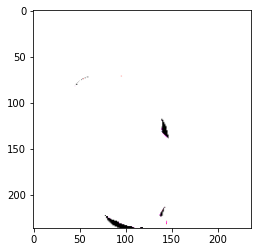

In [12]:
model = Sequential()
model.add(Conv2D(32,(3,3), activation='relu',input_shape=(236, 236,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    trainingData_generator,
    steps_per_epoch=totalTrainImages//32,
    epochs=50,
    validation_data=(validationData_generator,labels),
    validation_steps=totalValidationImages//32
)

loss, accuracy = model.evaluate(validationData_generator,labels,steps=totalValidationImages//32)
print(f"Validation loss: {loss: .4f}", f"Validation accuracy: {accuracy: .4f}")

Epoch 1/50
111/111 [==============================] - 175s 2s/step - loss: 2.6580 - accuracy: 0.6979 - val_loss: 0.5911 - val_accuracy: 0.7284
Epoch 2/50
111/111 [==============================] - 141s 1s/step - loss: 0.5407 - accuracy: 0.7413
Epoch 3/50
111/111 [==============================] - 148s 1s/step - loss: 0.5225 - accuracy: 0.7650
Epoch 4/50
111/111 [==============================] - 161s 1s/step - loss: 0.4941 - accuracy: 0.7867
Epoch 5/50
111/111 [==============================] - 161s 1s/step - loss: 0.4829 - accuracy: 0.7915
Epoch 6/50
111/111 [==============================] - 159s 1s/step - loss: 0.4706 - accuracy: 0.7988
Epoch 7/50
111/111 [==============================] - 156s 1s/step - loss: 0.4829 - accuracy: 0.8042
Epoch 8/50
111/111 [==============================] - 155s 1s/step - loss: 0.4556 - accuracy: 0.8090
Epoch 9/50
111/111 [==============================] - 155s 1s/step - loss: 0.4433 - accuracy: 0.8076
Epoch 10/50
111/111 [============================